In [11]:
#importing libraries
#reference : https://arxiv.org/pdf/1409.3215.pdf
#probem statement is  given a sequence [2,3,4,5,6]  seq_2seq will learn and do square of each number [4,9,16,25,36]

import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np

tf.reset_default_graph()



In [12]:
#some hyper parameters

encoder_vocab_size = 100  # suppose our encoding data vocab size is 100 
decoder_vocab_size = 150  # and decoding data vocab size is 150

batch_size=10

encoder_hidden_unit = 100
decoder_hidden_unit = 100

encoder_embedding_dim=50
decoder_embedding_dim=50


In [13]:
#inputs :  encoder_input , decoder_input , decoder_target


encoder_input = tf.placeholder(name='encoder_input',shape=[None,None],dtype=tf.int32)
decoder_input = tf.placeholder(name='decoder_input',shape=[None,None],dtype=tf.int32)
decoder_target= tf.placeholder(name='decoder_target',shape=[None,None],dtype=tf.int32)

#ecoder input should be  [Max_time,batch]  time major  
#decoder input should be [Max_time,batch]  time major
#decoder_target should be [Max_time,batch] time major
print(encoder_input)

Tensor("encoder_input:0", shape=(?, ?), dtype=int32)


In [14]:
#embedding for encoder , decoder



#use tf.get_variable instead of tf.Variable
encoder_embedding = tf.get_variable(name='encoder_embedding',
                                    shape=[encoder_vocab_size,encoder_embedding_dim],
                                    dtype=tf.float32,
                                    initializer=tf.random_uniform_initializer(-0.01,0.01))

decoder_embedding = tf.get_variable(name='decoder_embedding',
                                    shape=[decoder_vocab_size,decoder_embedding_dim],
                                    dtype=tf.float32,
                                    initializer=tf.random_uniform_initializer(-0.01,0.01))

embedd_encoder = tf.nn.embedding_lookup(encoder_embedding,encoder_input)
#now encoder input will become [ max_time , batch_size , embedding_dim ]

embedd_decoder = tf.nn.embedding_lookup(decoder_embedding,decoder_input)
#now decoder input will become [ max_time , batch_size , embedding_dim ]

print(embedd_encoder)

Tensor("embedding_lookup:0", shape=(?, ?, 50), dtype=float32)


In [15]:
#cell for rnn

encoder_cell = rnn.LSTMCell(num_units=encoder_hidden_unit)
decoder_cell = rnn.LSTMCell(num_units=decoder_hidden_unit)

In [16]:
#encoder

encoder_model, encoder_last_state = tf.nn.dynamic_rnn(cell=encoder_cell,
                                                      inputs=embedd_encoder,
                                                      time_major=True,
                                                      dtype=tf.float32)

In [17]:
#decoder 
decoder_output,decoder_last_state= tf.nn.dynamic_rnn(cell=decoder_cell,
                                                     inputs=embedd_decoder,
                                                     time_major=True,
                                                     initial_state=encoder_last_state,
                                                     dtype=tf.float32,
                                                     scope='decoder_inputs')


In [18]:
#projection layer without activation

linear_projection = tf.contrib.layers.fully_connected(decoder_output,decoder_vocab_size)


#taking max argument
prediction = tf.argmax(linear_projection,2)


In [19]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(decoder_target,
                                                     depth=decoder_vocab_size,dtype=tf.float32),
                                                     logits=linear_projection)

#reduce_mean
loss=tf.reduce_mean(cross_entropy)

#our aim is to minimize this loss


In [20]:
train = tf.train.AdamOptimizer().minimize(loss)

In [21]:
data=np.load('data_to_be_train.npy')

train_data_int=int(len(data)*0.80)

train_data = data[:train_data_int]
test_data  = data[train_data_int:]


In [22]:
PAD=0
EOS=1
def get_train_batch(value):
    train_data_ = train_data[value]
    max_len = max([len(i) for i in train_data_])
#     print(max_len)
    pad_data=[i+[0]*(max_len-len(i)) for i in train_data_ if len(i)<max_len]
    
    encoder_inpu   = pad_data
    decoder_inpu   = [[EOS] + [j*j for j in i ] for i in pad_data]
    decoder_target = [[j*j for j in i] +[EOS] + [0]*(max_len-len(i)) for i in train_data_ if len(i)<max_len]
    

    

    
    return {'encoder':np.transpose(np.array(encoder_inpu),[1,0]),
            'decoder_':np.transpose(np.array(decoder_inpu),[1,0]),
            'decoder_tar':np.transpose(np.array(decoder_target),[1,0])}

    
    
    
    
    
    

In [23]:
from tqdm import tqdm_notebook as tq
max_batches = 30
batches_in_epoch = 1
loss_track = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for batch in range(max_batches):
        for j in tq(range(len(train_data))):
            tr_da = get_train_batch(j)
            feed_dict={encoder_input:tr_da['encoder'],decoder_target:tr_da['decoder_tar'],decoder_input:tr_da['decoder_']}
            _, l = sess.run([train, loss],feed_dict)
            loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss,feed_dict)))
            predict_ = sess.run(prediction, feed_dict)
            
            print('    input     > {}'.format(tr_da['encoder']))
            print('    predicted > {}'.format(predict_))
            


batch 0
  minibatch loss: 1.759526014328003
    input     > [[4 6 2 6 6 7 8 5 2]
 [6 6 8 6 3 8 9 3 3]
 [3 9 2 8 9 3 9 6 2]
 [0 2 8 9 5 8 0 2 4]
 [0 6 4 4 3 9 0 0 0]
 [0 0 0 7 2 9 0 0 0]
 [0 0 0 8 2 2 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
    predicted > [[16 16 16 16  9 49 16 16  9]
 [16 16 16 16 49 49 16 16 49]
 [ 4 16 16 16 49 49  4 16 49]
 [ 1 16 16 16 49 49  1  4 49]
 [ 0  4  4 16 49 49  0  1  1]
 [ 0  1  1 81 49 49  0  0  0]
 [ 0  0  0  4 49 49  0  0  0]
 [ 0  0  0  1  4  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]



batch 1
  minibatch loss: 0.5196203589439392
    input     > [[4 6 2 6 6 7 8 5 2]
 [6 6 8 6 3 8 9 3 3]
 [3 9 2 8 9 3 9 6 2]
 [0 2 8 9 5 8 0 2 4]
 [0 6 4 4 3 9 0 0 0]
 [0 0 0 7 2 9 0 0 0]
 [0 0 0 8 2 2 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
    predicted > [[16 36  4 36 36 49 25 36 81]
 [36 36 36 36  9 36 81  9 81]
 [49 81  4 16 16  9 81 36  4]
 [ 1 81 64 81 25  4  1 81 16]
 [ 0 36 16 16  9 81  0  1  1]
 [ 0  1  1  4 81 81  0  0  0]
 [ 0  0  0 16 81  4  0  0  0]
 [ 0  0  0  1 49  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]



batch 2
  minibatch loss: 0.269411563873291
    input     > [[4 6 2 6 6 7 8 5 2]
 [6 6 8 6 3 8 9 3 3]
 [3 9 2 8 9 3 9 6 2]
 [0 2 8 9 5 8 0 2 4]
 [0 6 4 4 3 9 0 0 0]
 [0 0 0 7 2 9 0 0 0]
 [0 0 0 8 2 2 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
    predicted > [[16 36  4 36 36 49 25 25  4]
 [36 36 25 36  9 25 81  9  9]
 [ 9 81  4 16  4 49 81 36  4]
 [ 1  4 64 81 25 25  1  4 16]
 [ 0 36 16 16  9  4  0  1  1]
 [ 0  1  1 49  4  4  0  0  0]
 [ 0  0  0 64  9 64  0  0  0]
 [ 0  0  0  1  9  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]



batch 3
  minibatch loss: 0.1046612560749054
    input     > [[4 6 2 6 6 7 8 5 2]
 [6 6 8 6 3 8 9 3 3]
 [3 9 2 8 9 3 9 6 2]
 [0 2 8 9 5 8 0 2 4]
 [0 6 4 4 3 9 0 0 0]
 [0 0 0 7 2 9 0 0 0]
 [0 0 0 8 2 2 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
    predicted > [[16 36  4 36 36 49 64 25  4]
 [36 36 64 36  9 64 81  9  9]
 [ 9 81  4 64 81  9 81 36  4]
 [ 1  4 64 81 25 64  1  4 16]
 [ 0 36 16 16  9 81  0  1  1]
 [ 0  1  1 49  4 81  0  0  0]
 [ 0  0  0 64  9  4  0  0  0]
 [ 0  0  0  1  9  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]



batch 4
  minibatch loss: 0.030690694227814674
    input     > [[4 6 2 6 6 7 8 5 2]
 [6 6 8 6 3 8 9 3 3]
 [3 9 2 8 9 3 9 6 2]
 [0 2 8 9 5 8 0 2 4]
 [0 6 4 4 3 9 0 0 0]
 [0 0 0 7 2 9 0 0 0]
 [0 0 0 8 2 2 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
    predicted > [[16 36  4 36 36 49 64 25  4]
 [36 36 64 36  9 64 81  9  9]
 [ 9 81  4 64 81  9 81 36  4]
 [ 1  4 64 81 25 64  1  4 16]
 [ 0 36 16 16  9 81  0  1  1]
 [ 0  1  1 49  4 81  0  0  0]
 [ 0  0  0 64  4  4  0  0  0]
 [ 0  0  0  1  9  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]



batch 5
  minibatch loss: 0.015287562273442745
    input     > [[4 6 2 6 6 7 8 5 2]
 [6 6 8 6 3 8 9 3 3]
 [3 9 2 8 9 3 9 6 2]
 [0 2 8 9 5 8 0 2 4]
 [0 6 4 4 3 9 0 0 0]
 [0 0 0 7 2 9 0 0 0]
 [0 0 0 8 2 2 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
    predicted > [[16 36  4 36 36 49 64 25  4]
 [36 36 64 36  9 64 81  9  9]
 [ 9 81  4 64 81  9 81 36  4]
 [ 1  4 64 81 25 64  1  4 16]
 [ 0 36 16 16  9 81  0  1  1]
 [ 0  1  1 49  4 81  0  0  0]
 [ 0  0  0 64  4  4  0  0  0]
 [ 0  0  0  1  9  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]



batch 6
  minibatch loss: 0.012834947556257248
    input     > [[4 6 2 6 6 7 8 5 2]
 [6 6 8 6 3 8 9 3 3]
 [3 9 2 8 9 3 9 6 2]
 [0 2 8 9 5 8 0 2 4]
 [0 6 4 4 3 9 0 0 0]
 [0 0 0 7 2 9 0 0 0]
 [0 0 0 8 2 2 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
    predicted > [[16 36  4 36 36 49 64 25  4]
 [36 36 64 36  9 64 81  9  9]
 [ 9 81  4 64 81  9 81 36  4]
 [ 1  4 64 81 25 64  1  4 16]
 [ 0 36 16 16  9 81  0  1  1]
 [ 0  1  1 49  4 81  0  0  0]
 [ 0  0  0 64  4  4  0  0  0]
 [ 0  0  0  1  9  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]



batch 7
  minibatch loss: 0.011493828147649765
    input     > [[4 6 2 6 6 7 8 5 2]
 [6 6 8 6 3 8 9 3 3]
 [3 9 2 8 9 3 9 6 2]
 [0 2 8 9 5 8 0 2 4]
 [0 6 4 4 3 9 0 0 0]
 [0 0 0 7 2 9 0 0 0]
 [0 0 0 8 2 2 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
    predicted > [[16 36  4 36 36 49 64 25  4]
 [36 36 64 36  9 64 81  9  9]
 [ 9 81  4 64 81  9 81 36  4]
 [ 1  4 64 81 25 64  1  4 16]
 [ 0 36 16 16  9 81  0  1  1]
 [ 0  1  1 49  4 81  0  0  0]
 [ 0  0  0 64  4  4  0  0  0]
 [ 0  0  0  1  9  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]


KeyboardInterrupt: 

loss 0.0025 after 132910 examples (batch_size=10)


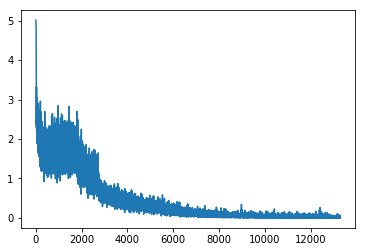

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))